# Seth Woodbury BioEn 599 Course Project

Coding guidelines are:

1. Whenever possible, use functions instead of scripts. This is because functions facilitate reuse, and functions are testable. Never use copy and paste for reuse.

1. Use meaningful names for functions are variables. Function names should be verbs. For example, a function that calculates a fast Fourier transform might be named ``calcFFT``. A bad name for this function would be the single letter ``f``.

1. Constants used in the notebook should have a name in all capital letters. For example, use PI, not pi. (By definition, a constant is a variable that is assigned a value only once.)

1. The following should be used for functions:

   1. Code cells should contain at most one function definition.

   1. Functions should contain documentation that specifies: (a) what it does; (b) data types and semantics of its input parameters; (c) data type and semantics of what it returns.

   1. The code cell in which a function resides should contain an "assert" statement that runs the function and performs a test on its output.


**Comments:**
1. 25/25. Overall, very well done. I had some problems running the notebook because of the Antimony you generated. See comments below. Also, some comments on your operating region below.
1. In the future, please do "Kernel>Restart Kernel and run all cells" before handing in.

## Organization & Installs/Imports

In [1]:
#!pip install -q tellurium
#!pip install -q control
#!pip -q install controlSBML

In [2]:
from controlSBML import ControlSBML

import tellurium as te
import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Homework 1: Problem Description & System Definition 

### Problem Description & Control Objectives for Biomodel Selection:

##### Biomodel -> Nishio2008 - Design of the phosphotransferase system for enhanced glucose uptake in E. coli  
##### Biomodel URL -> https://www.ebi.ac.uk/biomodels/BIOMD0000000571
##### Publication URL -> https://www.embopress.org/doi/full/10.1038/msb4100201

Industrial bioreactors culturing engineered microbes present a cost-effective, highly efficient, minimal-resource cost, and eco-friendly method of producing large quantities of desirable proteins and complex organic compounds for societal use (e.g., academia, therapeutics, industrial chemistry, biotechnology sectors). The biological problem I am addressing regards controlling Escherichia coli (E. coli) glucose uptake for such industrial microbe engineering purposes since they are the most well-studied and commonly used microbe. From a bioreactor production standpoint, it is desirable to have E. coli uptake as much glucose as possible for the ultimate production of ATP and the desired plasmid product(s) they were engineered to produce (i.e., protein products or protein machinery to make small organic molecules). However, E. coli have evolved to highly regulate their glucose uptake for the optimal cooperative survival and proliferation of their colonies; if they sense low glucose in the environment, they will try to use other carbon sources and metabolites for energy and they will shift toward conservative/catabolic metabolic processes rather than the anabolic ones we want them to perform. Ideally, we want E. coli in a bioreactor to initially divide to a certain concentration, then we want to induce them to grow as fat as possible (taking in the maximal possible glucose as fuel) to become full of our intended product before we lyse them all to harvest our product.

E. coli have evolved a complex phosphotransferase system that acts in a biological circuit to control the transfer of glucose into the cell while simultaneously phosphorylating it. The specific biological problem that I will be engineering in this system is how to control and enhance the concentration of ``phosphorylated EI`` or ``EI_P`` from the gene ptsI. The phosphotransfer of the phosphate on phosphoenolpyruvate to EI making EI_P is the first step in the phosphotransferase cascade system that ultimately phosphorylates glucose and transports it into the cell. This reaction is also thought to be the rate-limiting step in glucose intake so aiming to control and upregulate EI_P concentration will push equilibrium towards a higher glucose intake.

In the given model, the extracellular glucose concentration is held constant which could mimic a bioreactor that is continuously feeding E. coli glucose while they divide and grow before their plasmid expression is induced. At t = 500 minutes in the model the glucose levels drop instantaneously by several orders of magnitude to cause a perturbation (see below). As a reminder, we want to resist ``EI_P`` decrease at all costs and ideally minimize its increase from the reverse of the phosphotransferase cascade since the last step depends partially on glucose concentration and each phosphate transfer is reversible. Thus, our control objectives are:
* Keep the ``EI_P`` concentration in the range above 2.4e-7M at all costs but ideally [2.4e-7 M, 3.4e-7 M] for at least 600 minutes (6 hours) for t > 500 minutes and ideally 720 minutes (12 hours).
* Minimize or eliminate any potential concentration oscillations.
* Converge to a stable, steady-state system after the glucose decrease within 30 minutes.
* With each additional step this setting time should also be within t = 30 minutes & the final ``EI_P`` should steady out.

Achieving these control objectives will allow our engineered E. coli to keep maximally uptaking glucose even after we shut down its continuous flow into the bioreactor. Keeping the ``EI_P`` range above 2.4e-7 M is significant because this is its steady-state concentration at glucose concentrations that are magnitudes higher at t < 500 minutes, so maintaining an ``EI_P`` this high after t = 500 minutes will mean the E. coli are still uptaking glucose at a similar rate as before. Keeping it below 3.4e-7 M is a good sign that the rest of the phosphotransferase cascade is not backing up or slowing down significantly. Cells enjoy homeostasis and consistency, so minimizing ``EI_P`` oscillations will be important to not throw off other equilibriums that are not necessarily modeled here with respect to glucose uptake, we want a continuous flux of glucose coming in that keeps our E. coli busy at making proteins. Finally, 30 minutes is a pretty short time for E. coli so it would be desirable if the system could converge within 30 minutes so the E. coli are not thrown out of homeostasis.

**Comments:**
1. Very interesting problem description. Great translation in to a control problem.

#### Preliminary Investigation

In [3]:
## Obtain the Source File Data from the URL on the Biomodels Website, Load Tellurium SBML Model, & Optionally View Antimony

# Assign file URL to a variable
BIOMODEL_SOURCE_FILE_URL = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1501300000/3/BIOMD0000000571_url.xml"

# Create tellurium SBML model & optionally print the antimony
SBML_TE_MODEL = te.loadSBMLModel(BIOMODEL_SOURCE_FILE_URL)
#print(SBML_TE_MODEL.getAntimony()) # Inspect raw antimony

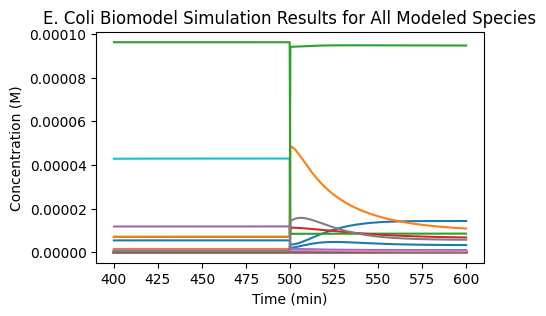

In [4]:
## View the Entire Simulation

# Load the SBML model from tellurium
SBML_TE_MODEL = te.loadSBMLModel(BIOMODEL_SOURCE_FILE_URL)

# Specify the simulation time range | NOTE: At t = 500 min the glucose concentration decreases drastically
start_time = 400
end_time = 600 

# Simulate the model for the specified time range
simulation_data = SBML_TE_MODEL.simulate(start_time, end_time, 500)
#print(simulation_data) # Viewing the raw simulation output values

# Plot the simulation results
plt.figure(figsize=(5, 3)) 

# Plot each species against time
for species in simulation_data.colnames[1:]:  # Exclude the 'time' column
    plt.plot(simulation_data['time'], simulation_data[species], label=species)

# Add itle, axes titles, & legend
plt.title('E. Coli Biomodel Simulation Results for All Modeled Species')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (M)')
#plt.legend() # Extremely messy with legend plotted on this

plt.show()

We can see that at t = 500 the sudden change in glucose quickly perturbes the system but it seems to quickly return to homeostasis. There are a ton of things being modeled here so let's take a look at ``EI_P``:

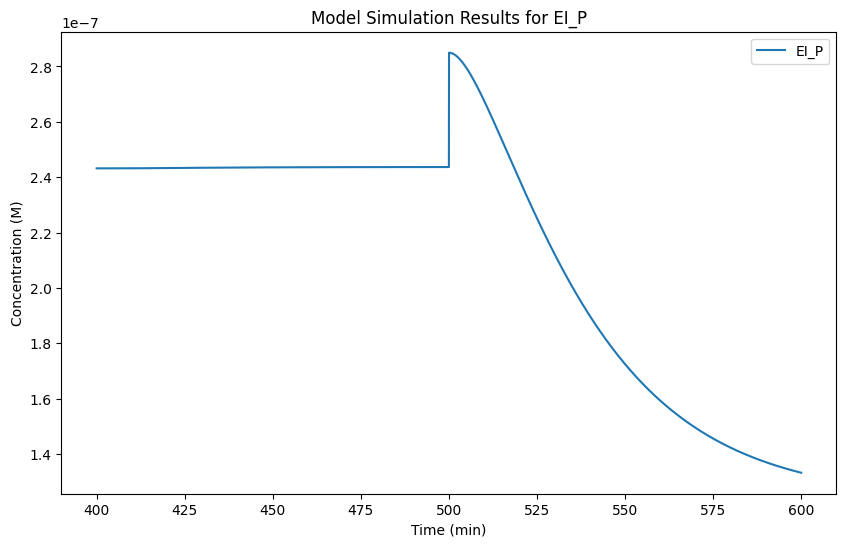

In [5]:
## View EI_P in the Simulation

# Reload the SBML model from tellurium
SBML_TE_MODEL = te.loadSBMLModel(BIOMODEL_SOURCE_FILE_URL)

# Specify the simulation time range
start_time = 400
end_time = 600

# Simulate the model for the specified time range
simulation_data = SBML_TE_MODEL.simulate(start_time, end_time, 50000, 
                                         selections= ["time", 'EI_P'])

# Plot the simulation results for specific species
plt.figure(figsize=(10, 6))

# Plot each species against time
for species in simulation_data.colnames[1:]:  # Exclude the 'time' column
    plt.plot(simulation_data['time'], simulation_data[species], label=species)

# Title, axes titles, & legend
plt.title('Model Simulation Results for EI_P')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (M)')
plt.legend()

# Show the plot
plt.show()

There it is, the glucose drop at t = 500 minutes causes a rapid backup in the phosphotransferase cascade due to the last species not being able to recruit glucose so quickly due to mass action and therefore ``EI_P`` accumulates before the genetic circuit catches up and calls for less EI protein production.

### System Definition

Remember that a system is defined by the following:
1. SBML model
1. Output
1. Input
1. Directional effect of the input on the output - agonist vs antagonist
1. Operating region for the input - range of input that gives output that makes sense
1. Range of outputs that can be achieved

We have already specified the SBML model and the ``EI_P`` output in our problem statement. Thus, we now seek to find an input that controls ``EI_P``.

#### Antimony Model

In [6]:
ANTIMONY_MODEL_EI_P = """
// Created by libAntimony v2.14.0
model *MODEL1501300000()

  // Compartments and Species:
  compartment cyt;
  species CRP in cyt, CRPsiteI_crp in cyt, CRPsiteII_crp in cyt, CRPsite_cyaA in cyt;
  species CRPsite_genome in cyt, CRPsite_ptsGp1 in cyt, CRPsite_ptsGp2 in cyt;
  species CRPsite_ptsHp0 in cyt, CRPsite_ptsHp1 in cyt, CRPsite_ptsIp0 in cyt;
  species CRPsite_ptsIp1 in cyt, CRPsite_mlcp1 in cyt, CRPsite_mlcp2 in cyt;
  species Mlc in cyt, Mlcsite_mlcp1 in cyt, Mlcsite_mlcp2 in cyt, Mlcsite_ptsGp1 in cyt;
  species Mlcsite_ptsGp2 in cyt, Mlcsite_ptsHp0 in cyt, Mlcsite_ptsIp0 in cyt;
  species CRP_cAMP in cyt, CRP_cAMP_CRPsiteI_crp in cyt, CRP_cAMP_CRPsiteII_crp in cyt;
  species CRP_cAMP_CRPsite_cyaA in cyt, CRP_cAMP_CRPsite_genome in cyt, CRP_cAMP_CRPsite_ptsGp1 in cyt;
  species CRP_cAMP_CRPsite_ptsGp2 in cyt, CRP_cAMP_CRPsite_ptsHp0 in cyt;
  species CRP_cAMP_CRPsite_ptsHp1 in cyt, CRP_cAMP_CRPsite_ptsIp0 in cyt;
  species CRP_cAMP_CRPsite_ptsIp1 in cyt, CRP_cAMP_CRPsite_mlcp1 in cyt, CRP_cAMP_CRPsite_mlcp2 in cyt;
  species Mlc_Mlcsite_ptsGp1 in cyt, Mlc_Mlcsite_ptsGp2 in cyt, Mlc_Mlcsite_ptsIp0 in cyt;
  species Mlc_Mlcsite_ptsHp0 in cyt, Mlc_Mlcsite_mlcp1 in cyt, Mlc_Mlcsite_mlcp2 in cyt;
  species IICB in cyt, IICB_Mlc in cyt, CYA in cyt, IIA_P in cyt, IIA_P_CYA in cyt;
  species mRNA_cyaA in cyt, mRNA_crp in cyt, mRNA_ptsG in cyt, mRNA_ptsH in cyt;
  species mRNA_ptsI in cyt, mRNA_crr in cyt, mRNA_mlc in cyt, IICB_P in cyt;
  species IIA in cyt, HPr_P in cyt, HPr in cyt, EI_P in cyt, EI in cyt, cAMP in cyt;
  species $cyaA in cyt, $cyaA_basal in cyt, $crp in cyt, $crp_basal in cyt;
  species $ptsGp1 in cyt, $ptsGp2 in cyt, $ptsHp0 in cyt, $ptsHp1 in cyt;
  species $ptsIp0 in cyt, $ptsIp1 in cyt, $crr in cyt, $mlcp1 in cyt, $mlcp2 in cyt;
  species $Pyr in cyt, $PEP in cyt, $Glc6P in cyt, $Glucose in cyt, $ATP in cyt;

  // Assignment Rules:
  TCRPsite_cyaA := CRPsite_cyaA + CRP_cAMP_CRPsite_cyaA;
  TCRPsiteI_crp := CRPsiteI_crp + CRP_cAMP_CRPsiteI_crp;
  TCRPsiteII_crp := CRPsiteII_crp + CRP_cAMP_CRPsiteII_crp;
  TCRPsite_ptsGp1 := CRPsite_ptsGp1 + CRP_cAMP_CRPsite_ptsGp1;
  TMlcsite_ptsGp1 := Mlcsite_ptsGp1 + Mlc_Mlcsite_ptsGp1;
  TCRPsite_ptsGp2 := CRPsite_ptsGp2 + CRP_cAMP_CRPsite_ptsGp2;
  TMlcsite_ptsGp2 := Mlcsite_ptsGp2 + Mlc_Mlcsite_ptsGp2;
  TCRPsite_ptsHp0 := CRPsite_ptsHp0 + CRP_cAMP_CRPsite_ptsHp0;
  TMlcsite_ptsHp0 := Mlcsite_ptsHp0 + Mlc_Mlcsite_ptsHp0;
  TCRPsite_ptsHp1 := CRPsite_ptsHp1 + CRP_cAMP_CRPsite_ptsHp1;
  TCRPsite_ptsIp0 := CRPsite_ptsIp0 + CRP_cAMP_CRPsite_ptsIp0;
  TMlcsite_ptsIp0 := Mlcsite_ptsIp0 + Mlc_Mlcsite_ptsIp0;
  TCRPsite_ptsIp1 := CRPsite_ptsIp1 + CRP_cAMP_CRPsite_ptsIp1;
  TCRPsite_mlcp1 := CRPsite_mlcp1 + CRP_cAMP_CRPsite_mlcp1;
  TMlcsite_mlcp1 := Mlcsite_mlcp1 + Mlc_Mlcsite_mlcp1;
  TCRPsite_mlcp2 := CRPsite_mlcp2 + CRP_cAMP_CRPsite_mlcp2;
  TMlcsite_mlcp2 := Mlcsite_mlcp2 + Mlc_Mlcsite_mlcp2;

  // Reactions:
  binding_CRP_cAMP: CRP + cAMP -> CRP_cAMP; cyt*fast*binding_CRP_cAMP_one_per_M*(binding_CRP_cAMP_Kb^2*(CRP*cAMP)^2 - CRP_cAMP^2);
  binding_CRP_cAMP_CRPsite_cyaA: CRP_cAMP + CRPsite_cyaA -> CRP_cAMP_CRPsite_cyaA; cyt*fast*(binding_CRP_cAMP_CRPsite_cyaA_Kb*CRP_cAMP*CRPsite_cyaA - CRP_cAMP_CRPsite_cyaA);
  binding_CRP_cAMP_CRPsiteI_crp: CRP_cAMP + CRPsiteI_crp -> CRP_cAMP_CRPsiteI_crp; cyt*fast*(binding_CRP_cAMP_CRPsiteI_crp_Kb*CRP_cAMP*CRPsiteI_crp - CRP_cAMP_CRPsiteI_crp);
  binding_CRP_cAMP_CRPsiteII_crp: CRP_cAMP + CRPsiteII_crp -> CRP_cAMP_CRPsiteII_crp; cyt*fast*(binding_CRP_cAMP_CRPsiteII_crp_Kb*CRP_cAMP*CRPsiteII_crp - CRP_cAMP_CRPsiteII_crp);
  binding_CRP_cAMP_CRPsite_ptsGp1: CRP_cAMP + CRPsite_ptsGp1 -> CRP_cAMP_CRPsite_ptsGp1; cyt*fast*(binding_CRP_cAMP_CRPsite_ptsGp1_Kb*CRP_cAMP*CRPsite_ptsGp1 - CRP_cAMP_CRPsite_ptsGp1);
  binding_CRP_cAMP_CRPsite_ptsGp2: CRP_cAMP + CRPsite_ptsGp2 -> CRP_cAMP_CRPsite_ptsGp2; cyt*fast*(binding_CRP_cAMP_CRPsite_ptsGp2_Kb*CRP_cAMP*CRPsite_ptsGp2 - CRP_cAMP_CRPsite_ptsGp2);
  binding_CRP_cAMP_CRPsite_ptsHp0: CRP_cAMP + CRPsite_ptsHp0 -> CRP_cAMP_CRPsite_ptsHp0; cyt*fast*(binding_CRP_cAMP_CRPsite_ptsHp0_Kb*CRP_cAMP*CRPsite_ptsHp0 - CRP_cAMP_CRPsite_ptsHp0);
  binding_CRP_cAMP_CRPsite_ptsHp1: CRP_cAMP + CRPsite_ptsHp1 -> CRP_cAMP_CRPsite_ptsHp1; cyt*fast*(binding_CRP_cAMP_CRPsite_ptsHp1_Kb*CRP_cAMP*CRPsite_ptsHp1 - CRP_cAMP_CRPsite_ptsHp1);
  binding_CRP_cAMP_CRPsite_ptsIp0: CRP_cAMP + CRPsite_ptsIp0 -> CRP_cAMP_CRPsite_ptsIp0; cyt*fast*(binding_CRP_cAMP_CRPsite_ptsIp0_Kb*CRP_cAMP*CRPsite_ptsIp0 - CRP_cAMP_CRPsite_ptsIp0);
  binding_CRP_cAMP_CRPsite_ptsIp1: CRP_cAMP + CRPsite_ptsIp1 -> CRP_cAMP_CRPsite_ptsIp1; cyt*fast*(binding_CRP_cAMP_CRPsite_ptsIp1_Kb*CRP_cAMP*CRPsite_ptsIp1 - CRP_cAMP_CRPsite_ptsIp1);
  binding_CRP_cAMP_CRPsite_mlcp1: CRP_cAMP + CRPsite_mlcp1 -> CRP_cAMP_CRPsite_mlcp1; cyt*fast*(binding_CRP_cAMP_CRPsite_mlcp1_Kb*CRP_cAMP*CRPsite_mlcp1 - CRP_cAMP_CRPsite_mlcp1);
  binding_CRP_cAMP_CRPsite_mlcp2: CRP_cAMP + CRPsite_mlcp2 -> CRP_cAMP_CRPsite_mlcp2; cyt*fast*(binding_CRP_cAMP_CRPsite_mlcp2_Kb*CRP_cAMP*CRPsite_mlcp2 - CRP_cAMP_CRPsite_mlcp2);
  binding_CRP_cAMP_CRPsite_genome: CRP_cAMP + CRPsite_genome -> CRP_cAMP_CRPsite_genome; cyt*fast*(binding_CRP_cAMP_CRPsite_genome_Kb*CRP_cAMP*CRPsite_genome - CRP_cAMP_CRPsite_genome);
  binding_Mlc_Mlcsite_ptsGp1: Mlc + Mlcsite_ptsGp1 -> Mlc_Mlcsite_ptsGp1; cyt*fast*(binding_Mlc_Mlcsite_ptsGp1_Kb*Mlc*Mlcsite_ptsGp1 - Mlc_Mlcsite_ptsGp1);
  binding_Mlc_Mlcsite_ptsGp2: Mlc + Mlcsite_ptsGp2 -> Mlc_Mlcsite_ptsGp2; cyt*fast*(binding_Mlc_Mlcsite_ptsGp2_Kb*Mlc*Mlcsite_ptsGp2 - Mlc_Mlcsite_ptsGp2);
  binding_Mlc_Mlcsite_ptsHp0: Mlc + Mlcsite_ptsHp0 -> Mlc_Mlcsite_ptsHp0; cyt*fast*(binding_Mlc_Mlcsite_ptsHp0_Kb*Mlc*Mlcsite_ptsHp0 - Mlc_Mlcsite_ptsHp0);
  binding_Mlc_Mlcsite_ptsIp0: Mlc + Mlcsite_ptsIp0 -> Mlc_Mlcsite_ptsIp0; cyt*fast*(binding_Mlc_Mlcsite_ptsIp0_Kb*Mlc*Mlcsite_ptsIp0 - Mlc_Mlcsite_ptsIp0);
  binding_Mlc_Mlcsite_mlcp1: Mlc + Mlcsite_mlcp1 -> Mlc_Mlcsite_mlcp1; cyt*fast*(binding_Mlc_Mlcsite_mlcp1_Kb*Mlc*Mlcsite_mlcp1 - Mlc_Mlcsite_mlcp1);
  binding_Mlc_Mlcsite_mlcp2: Mlc + Mlcsite_mlcp2 -> Mlc_Mlcsite_mlcp2; cyt*fast*(binding_Mlc_Mlcsite_mlcp2_Kb*Mlc*Mlcsite_mlcp2 - Mlc_Mlcsite_mlcp2);
  binding_IICB_Mlc: IICB + Mlc -> IICB_Mlc; cyt*fast*(binding_IICB_Mlc_Kb*IICB*Mlc - IICB_Mlc);
  binding_IIA_P_CYA: CYA + IIA_P -> IIA_P_CYA; cyt*fast*(binding_IIA_P_CYA_Kb*CYA*IIA_P^2 - IIA_P_CYA);
  transcription_CRP_cAMP_CRPsite_cyaA_cyaA:  -> mRNA_cyaA; cyt*transcription_CRP_cAMP_CRPsite_cyaA_cyaA_km*(1 - CRP_cAMP_CRPsite_cyaA/TCRPsite_cyaA)*cyaA;
  transcription_cyaA_basal:  -> mRNA_cyaA; cyt*transcription_cyaA_basal_km*cyaA_basal;
  transcription_CRP_cAMP_CRPsiteI_crp_CRP_cAMP_CRPsiteII_crp_crp:  -> mRNA_crp; cyt*transcription_CRP_cAMP_CRPsiteI_crp_CRP_cAMP_CRPsiteII_crp_crp_km*(1 + transcription_CRP_cAMP_CRPsiteI_crp_CRP_cAMP_CRPsiteII_crp_crp_RelativeactivityatTCRPsiteII_crp*CRP_cAMP_CRPsiteII_crp/TCRPsiteII_crp - CRP_cAMP_CRPsiteI_crp/TCRPsiteI_crp)*crp;
  transcription_crp_basal:  -> mRNA_crp; cyt*transcription_crp_basal_km*crp_basal;
  transcription_CRP_cAMP_CRPsite_ptsGp1_Mlc_Mlcsite_ptsGp1_ptsGp1:  -> mRNA_ptsG; cyt*transcription_CRP_cAMP_CRPsite_ptsGp1_Mlc_Mlcsite_ptsGp1_ptsGp1_km*(CRP_cAMP_CRPsite_ptsGp1/TCRPsite_ptsGp1)*(1 - Mlc_Mlcsite_ptsGp1/TMlcsite_ptsGp1)*ptsGp1;
  transcription_CRP_cAMP_CRPsite_ptsGp2_Mlc_Mlcsite_ptsGp2_ptsGp2:  -> mRNA_ptsG; cyt*transcription_CRP_cAMP_CRPsite_ptsGp2_Mlc_Mlcsite_ptsGp2_ptsGp2_km*(CRP_cAMP_CRPsite_ptsGp2/TCRPsite_ptsGp2)*(1 - Mlc_Mlcsite_ptsGp2/TMlcsite_ptsGp2)*ptsGp2;
  transcription_CRP_cAMP_CRPsite_ptsHp0_Mlc_Mlcsite_ptsHp0_ptsHp0:  -> mRNA_ptsH; cyt*transcription_CRP_cAMP_CRPsite_ptsHp0_Mlc_Mlcsite_ptsHp0_ptsHp0_km*(CRP_cAMP_CRPsite_ptsHp0/TCRPsite_ptsHp0)*(1 - Mlc_Mlcsite_ptsHp0/TMlcsite_ptsHp0)*ptsHp0;
  transcription_CRP_cAMP_CRPsite_ptsHp1_ptsHp1:  -> mRNA_ptsH; cyt*transcription_CRP_cAMP_CRPsite_ptsHp1_ptsHp1_km*(CRP_cAMP_CRPsite_ptsHp1/TCRPsite_ptsHp1)*ptsHp1;
  transcription_CRP_cAMP_CRPsite_ptsIp0_Mlc_Mlcsite_ptsIp0_ptsIp0:  -> mRNA_ptsI; cyt*transcription_CRP_cAMP_CRPsite_ptsIp0_Mlc_Mlcsite_ptsIp0_ptsIp0_km*(CRP_cAMP_CRPsite_ptsIp0/TCRPsite_ptsIp0)*(1 - Mlc_Mlcsite_ptsIp0/TMlcsite_ptsIp0)*ptsIp0;
  transcription_CRP_cAMP_CRPsite_ptsIp1_ptsIp1:  -> mRNA_ptsI; cyt*transcription_CRP_cAMP_CRPsite_ptsIp1_ptsIp1_km*(CRP_cAMP_CRPsite_ptsIp1/TCRPsite_ptsIp1)*ptsIp1;
  transcription_crr:  -> mRNA_crr; cyt*transcription_crr_km*crr;
  transcription_CRP_cAMP_CRPsite_mlcp1_Mlc_Mlcsite_mlcp1_mlcp1:  -> mRNA_mlc; cyt*transcription_CRP_cAMP_CRPsite_mlcp1_Mlc_Mlcsite_mlcp1_mlcp1_km*(1 - CRP_cAMP_CRPsite_mlcp1/TCRPsite_mlcp1)*(1 - Mlc_Mlcsite_mlcp1/TMlcsite_mlcp1)*mlcp1;
  transcription_CRP_cAMP_CRPsite_mlcp2_Mlc_Mlcsite_mlcp2_mlcp2:  -> mRNA_mlc; cyt*transcription_CRP_cAMP_CRPsite_mlcp2_Mlc_Mlcsite_mlcp2_mlcp2_km*(CRP_cAMP_CRPsite_mlcp2/TCRPsite_mlcp2)*(1 - Mlc_Mlcsite_mlcp2/TMlcsite_mlcp2)*mlcp2;
  decomposition_mRNA_cyaA: mRNA_cyaA -> ; cyt*decomposition_mRNA_cyaA_kmd*mRNA_cyaA;
  decomposition_mRNA_crp: mRNA_crp -> ; cyt*decomposition_mRNA_crp_kmd*mRNA_crp;
  decomposition_mRNA_ptsG: mRNA_ptsG -> ; cyt*decomposition_mRNA_ptsG_kmd*mRNA_ptsG;
  decomposition_mRNA_ptsH: mRNA_ptsH -> ; cyt*decomposition_mRNA_ptsH_kmd*mRNA_ptsH;
  decomposition_mRNA_ptsI: mRNA_ptsI -> ; cyt*decomposition_mRNA_ptsI_kmd*mRNA_ptsI;
  decomposition_mRNA_crr: mRNA_crr -> ; cyt*decomposition_mRNA_crr_kmd*mRNA_crr;
  decomposition_mRNA_mlc: mRNA_mlc -> ; cyt*decomposition_mRNA_mlc_kmd*mRNA_mlc;
  translation_mRNA_cyaA:  -> CYA; cyt*translation_mRNA_cyaA_kp*mRNA_cyaA;
  translation_mRNA_crp:  -> CRP; cyt*translation_mRNA_crp_kp*mRNA_crp;
  translation_mRNA_ptsG:  -> IICB; cyt*translation_mRNA_ptsG_kp*mRNA_ptsG;
  translation_mRNA_ptsH:  -> HPr; cyt*translation_mRNA_ptsH_kp*mRNA_ptsH;
  translation_mRNA_ptsI:  -> EI; cyt*translation_mRNA_ptsI_kp*mRNA_ptsI;
  translation_mRNA_crr:  -> IIA; cyt*translation_mRNA_crr_kp*mRNA_crr;
  translation_mlc:  -> Mlc; cyt*translation_mlc_kp*mRNA_mlc;
  decomposition_CYA: CYA -> ; cyt*decomposition_CYA_kpd*CYA;
  decomposition_CRP: CRP -> ; cyt*decomposition_CRP_kpd*CRP;
  decomposition_Mlc: Mlc -> ; cyt*decomposition_Mlc_kpd*Mlc;
  decomposition_cAMP: cAMP -> ; cyt*decomposition_cAMP_kpd*cAMP;
  decomposition_CRP_cAMP: CRP_cAMP -> ; cyt*decomposition_CRP_cAMP_kpd*CRP_cAMP;
  decomposition_CRP_cAMP_CRPsite_cyaA: CRP_cAMP_CRPsite_cyaA -> CRPsite_cyaA; cyt*decomposition_CRP_cAMP_CRPsite_cyaA_kpd*CRP_cAMP_CRPsite_cyaA;
  decomposition_CRP_cAMP_CRPsiteI_crp: CRP_cAMP_CRPsiteI_crp -> CRPsiteI_crp; cyt*decomposition_CRP_cAMP_CRPsiteI_crp_kpd*CRP_cAMP_CRPsiteI_crp;
  decomposition_CRP_cAMP_CRPsiteII_crp: CRP_cAMP_CRPsiteII_crp -> CRPsiteII_crp; cyt*decomposition_CRP_cAMP_CRPsiteII_crp_kpd*CRP_cAMP_CRPsiteII_crp;
  decomposition_CRP_cAMP_CRPsite_ptsGp1: CRP_cAMP_CRPsite_ptsGp1 -> CRPsite_ptsGp1; cyt*decomposition_CRP_cAMP_CRPsite_ptsGp1_kpd*CRP_cAMP_CRPsite_ptsGp1;
  decomposition_CRP_cAMP_CRPsite_ptsGp2: CRP_cAMP_CRPsite_ptsGp2 -> CRPsite_ptsGp2; cyt*decomposition_CRP_cAMP_CRPsite_ptsGp2_kpd*CRP_cAMP_CRPsite_ptsGp2;
  decomposition_CRP_cAMP_CRPsite_ptsHp0: CRP_cAMP_CRPsite_ptsHp0 -> CRPsite_ptsHp0; cyt*decomposition_CRP_cAMP_CRPsite_ptsHp0_kpd*CRP_cAMP_CRPsite_ptsHp0;
  decomposition_CRP_cAMP_CRPsite_ptsHp1: CRP_cAMP_CRPsite_ptsHp1 -> CRPsite_ptsHp1; cyt*decomposition_CRP_cAMP_CRPsite_ptsHp1_kpd*CRP_cAMP_CRPsite_ptsHp1;
  decomposition_CRP_cAMP_CRPsite_ptsIp0: CRP_cAMP_CRPsite_ptsIp0 -> CRPsite_ptsIp0; cyt*decomposition_CRP_cAMP_CRPsite_ptsIp0_kpd*CRP_cAMP_CRPsite_ptsIp0;
  decomposition_CRP_cAMP_CRPsite_ptsIp1: CRP_cAMP_CRPsite_ptsIp1 -> CRPsite_ptsIp1; cyt*decomposition_CRP_cAMP_CRPsite_ptsIp1_kpd*CRP_cAMP_CRPsite_ptsIp1;
  decomposition_CRP_cAMP_CRPsite_mlcp1: CRP_cAMP_CRPsite_mlcp1 -> CRPsite_mlcp1; cyt*decomposition_CRP_cAMP_CRPsite_mlcp1_kpd*CRP_cAMP_CRPsite_mlcp1;
  decomposition_CRP_cAMP_CRPsite_mlcp2: CRP_cAMP_CRPsite_mlcp2 -> CRPsite_mlcp2; cyt*decomposition_CRP_cAMP_CRPsite_mlcp2_kpd*CRP_cAMP_CRPsite_mlcp2;
  decomposition_CRP_cAMP_CRPsite_genome: CRP_cAMP_CRPsite_genome -> CRPsite_genome; cyt*decomposition_CRP_cAMP_CRPsite_genome_kpd*CRP_cAMP_CRPsite_genome;
  decomposition_Mlc_Mlcsite_ptsGp1: Mlc_Mlcsite_ptsGp1 -> Mlcsite_ptsGp1; cyt*decomposition_Mlc_Mlcsite_ptsGp1_kpd*Mlc_Mlcsite_ptsGp1;
  decomposition_Mlc_Mlcsite_ptsGp2: Mlc_Mlcsite_ptsGp2 -> Mlcsite_ptsGp2; cyt*decomposition_Mlc_Mlcsite_ptsGp2_kpd*Mlc_Mlcsite_ptsGp2;
  decomposition_Mlc_Mlcsite_ptsHp0: Mlc_Mlcsite_ptsHp0 -> Mlcsite_ptsHp0; cyt*decomposition_Mlc_Mlcsite_ptsHp0_kpd*Mlc_Mlcsite_ptsHp0;
  decomposition_Mlc_Mlcsite_ptsIp0: Mlc_Mlcsite_ptsIp0 -> Mlcsite_ptsIp0; cyt*decomposition_Mlc_Mlcsite_ptsIp0_kpd*Mlc_Mlcsite_ptsIp0;
  decomposition_Mlc_Mlcsite_mlcp1: Mlc_Mlcsite_mlcp1 -> Mlcsite_mlcp1; cyt*decomposition_Mlc_Mlcsite_mlcp1_kpd*Mlc_Mlcsite_mlcp1;
  decomposition_Mlc_Mlcsite_mlcp2: Mlc_Mlcsite_mlcp2 -> Mlcsite_mlcp2; cyt*decomposition_Mlc_Mlcsite_mlcp2_kpd*Mlc_Mlcsite_mlcp2;
  decomposition_IICB_Mlc: IICB_Mlc -> ; cyt*decomposition_IICB_Mlc_kpd*IICB_Mlc;
  decomposition_EI_P: EI_P -> ; cyt*decomposition_EI_P_kpd*EI_P;
  decomposition_EI: EI -> ; cyt*decomposition_EI_kpd*EI;
  decomposition_HPr_P: HPr_P -> ; cyt*decomposition_HPr_P_kpd*HPr_P;
  decomposition_HPr: HPr -> ; cyt*decomposition_HPr_kpd*HPr;
  decomposition_IIA_P: IIA_P -> ; cyt*decomposition_IIA_P_kpd*IIA_P;
  decomposition_IIA: IIA -> ; cyt*decomposition_IIA_kpd*IIA;
  decomposition_IICB_P: IICB_P -> ; cyt*decomposition_IICB_P_kpd*IICB_P;
  decomposition_IICB: IICB -> ; cyt*decomposition_IICB_kpd*IICB;
  PTS2for: HPr + EI_P -> HPr_P + EI; cyt*PTS2for_kx*HPr*EI_P;
  PTS2rev: HPr_P + EI -> HPr + EI_P; cyt*PTS2rev_kx*EI*HPr_P;
  PTS3for: IIA + HPr_P -> IIA_P + HPr; cyt*PTS3for_kx*IIA*HPr_P;
  PTS3rev: IIA_P + HPr -> IIA + HPr_P; cyt*PTS3rev_kx*HPr*IIA_P;
  PTS4for: IICB + IIA_P -> IICB_P + IIA; cyt*PTS4for_kx*IICB*IIA_P;
  PTS4rev: IICB_P + IIA -> IICB + IIA_P; cyt*PTS4rev_kx*IIA*IICB_P;
  reaction_CYA_ATP: $ATP -> cAMP; cyt*(reaction_CYA_ATP_Q*CYA*ATP/(reaction_CYA_ATP_Kmich + ATP));
  reaction_IIA_P_CYA_ATP: $ATP -> cAMP; cyt*(reaction_IIA_P_CYA_ATP_Q*IIA_P_CYA*ATP/(reaction_IIA_P_CYA_ATP_Kmich + ATP));
  reaction_EI_PEP: EI + $PEP -> EI_P + $Pyr; cyt*(2*reaction_EI_PEP_Q*EI*PEP^2/(reaction_EI_PEP_Kmich^2 + PEP^2));
  reaction_EIP_Pyr: EI_P + $Pyr -> EI + $PEP; cyt*(2*reaction_EIP_Pyr_Q*EI_P*Pyr^2/(reaction_EIP_Pyr_Kmich^2 + Pyr^2));
  reaction_IICB_P_Glucose: IICB_P + $Glucose -> IICB + $Glc6P; cyt*(reaction_IICB_P_Glucose_Q*IICB_P*Glucose/(reaction_IICB_P_Glucose_Kmich + Glucose));
  reaction_IICB_Glc6P: IICB + $Glc6P -> IICB_P + $Glucose; cyt*(reaction_IICB_Glc6P_Q*IICB*Glc6P/(reaction_IICB_Glc6P_Kmich + Glc6P));

  // Events:
  _E0: at time >= 500: Glucose = 2e-9;

  // Species initializations:
  CRP = 5.4207e-06;
  CRPsiteI_crp = 7.4368e-11;
  CRPsiteII_crp = 1.9047e-10;
  CRPsite_cyaA = 3.1103e-11;
  CRPsite_genome = 3.6756e-09;
  CRPsite_ptsGp1 = 1.2021e-10;
  CRPsite_ptsGp2 = 1.2021e-10;
  CRPsite_ptsHp0 = 1.2021e-10;
  CRPsite_ptsHp1 = 1.2021e-10;
  CRPsite_ptsIp0 = 1.2021e-10;
  CRPsite_ptsIp1 = 1.2021e-10;
  CRPsite_mlcp1 = 1.2021e-10;
  CRPsite_mlcp2 = 1.2021e-10;
  Mlc = 5.5172e-10;
  Mlcsite_mlcp1 = 2.4267e-10;
  Mlcsite_mlcp2 = 2.4282e-10;
  Mlcsite_ptsGp1 = 2.1885e-10;
  Mlcsite_ptsGp2 = 2.1885e-10;
  Mlcsite_ptsHp0 = 2.1885e-10;
  Mlcsite_ptsIp0 = 2.1885e-10;
  CRP_cAMP = 1.0214e-07;
  CRP_cAMP_CRPsiteI_crp = 1.6863e-10;
  CRP_cAMP_CRPsiteII_crp = 5.2529e-11;
  CRP_cAMP_CRPsite_cyaA = 2.119e-10;
  CRP_cAMP_CRPsite_genome = 3.7544e-09;
  CRP_cAMP_CRPsite_ptsGp1 = 1.2279e-10;
  CRP_cAMP_CRPsite_ptsGp2 = 1.2279e-10;
  CRP_cAMP_CRPsite_ptsHp0 = 1.2279e-10;
  CRP_cAMP_CRPsite_ptsHp1 = 1.2279e-10;
  CRP_cAMP_CRPsite_ptsIp0 = 1.2279e-10;
  CRP_cAMP_CRPsite_ptsIp1 = 1.2279e-10;
  CRP_cAMP_CRPsite_mlcp1 = 1.2279e-10;
  CRP_cAMP_CRPsite_mlcp2 = 1.2279e-10;
  Mlc_Mlcsite_ptsGp1 = 2.4149e-11;
  Mlc_Mlcsite_ptsGp2 = 2.4149e-11;
  Mlc_Mlcsite_ptsIp0 = 2.4149e-11;
  Mlc_Mlcsite_ptsHp0 = 2.4149e-11;
  Mlc_Mlcsite_mlcp1 = 3.2535e-13;
  Mlc_Mlcsite_mlcp2 = 1.8086e-13;
  IICB = 4.2844e-05;
  IICB_Mlc = 1.6546e-07;
  CYA = 1.4934e-06;
  IIA_P = 7.0094e-06;
  IIA_P_CYA = 7.3371e-09;
  mRNA_cyaA = 1.3643e-08;
  mRNA_crp = 5.0254e-08;
  mRNA_ptsG = 4.5559e-07;
  mRNA_ptsH = 1.1411e-07;
  mRNA_ptsI = 1.0038e-08;
  mRNA_crr = 9.3861e-07;
  mRNA_mlc = 1.5101e-09;
  IICB_P = 7.1055e-06;
  IIA = 9.623e-05;
  HPr_P = 7.5867e-07;
  HPr = 1.1793e-05;
  EI_P = 2.4319e-07;
  EI = 8.6098e-07;
  cAMP = 4.7107e-07;
  cyaA = 2.43e-10;
  cyaA_basal = 2.43e-10;
  crp = 2.43e-10;
  crp_basal = 2.43e-10;
  ptsGp1 = 2.43e-10;
  ptsGp2 = 2.43e-10;
  ptsHp0 = 2.43e-10;
  ptsHp1 = 2.43e-10;
  ptsIp0 = 2.43e-10;
  ptsIp1 = 2.43e-10;
  crr = 2.43e-10;
  mlcp1 = 2.43e-10;
  mlcp2 = 2.43e-10;
  Pyr = 0.00267;
  PEP = 0.00267;
  Glc6P = 0.00148;
  Glucose = 0.2;
  ATP = 0.0069942;

  // Compartment initializations:
  cyt = 1;

  // Variable initializations:
  fast = 1000000000;
  fast has per_min;
  TCRPsite_cyaA has M;
  TCRPsiteI_crp has M;
  TCRPsiteII_crp has M;
  TCRPsite_ptsGp1 has M;
  TMlcsite_ptsGp1 has M;
  TCRPsite_ptsGp2 has M;
  TMlcsite_ptsGp2 has M;
  TCRPsite_ptsHp0 has M;
  TMlcsite_ptsHp0 has M;
  TCRPsite_ptsHp1 has M;
  TCRPsite_ptsIp0 has M;
  TMlcsite_ptsIp0 has M;
  TCRPsite_ptsIp1 has M;
  TCRPsite_mlcp1 has M;
  TMlcsite_mlcp1 has M;
  TCRPsite_mlcp2 has M;
  TMlcsite_mlcp2 has M;
  binding_CRP_cAMP_Kb = 40000;
  binding_CRP_cAMP_Kb has per_M;
  binding_CRP_cAMP_one_per_M = 1;
  binding_CRP_cAMP_one_per_M has per_M;
  binding_CRP_cAMP_CRPsite_cyaA_Kb = 66700000;
  binding_CRP_cAMP_CRPsite_cyaA_Kb has per_M;
  binding_CRP_cAMP_CRPsiteI_crp_Kb = 22200000;
  binding_CRP_cAMP_CRPsiteI_crp_Kb has per_M;
  binding_CRP_cAMP_CRPsiteII_crp_Kb = 2700000;
  binding_CRP_cAMP_CRPsiteII_crp_Kb has per_M;
  binding_CRP_cAMP_CRPsite_ptsGp1_Kb = 10000000;
  binding_CRP_cAMP_CRPsite_ptsGp1_Kb has per_M;
  binding_CRP_cAMP_CRPsite_ptsGp2_Kb = 10000000;
  binding_CRP_cAMP_CRPsite_ptsGp2_Kb has per_M;
  binding_CRP_cAMP_CRPsite_ptsHp0_Kb = 10000000;
  binding_CRP_cAMP_CRPsite_ptsHp0_Kb has per_M;
  binding_CRP_cAMP_CRPsite_ptsHp1_Kb = 10000000;
  binding_CRP_cAMP_CRPsite_ptsHp1_Kb has per_M;
  binding_CRP_cAMP_CRPsite_ptsIp0_Kb = 10000000;
  binding_CRP_cAMP_CRPsite_ptsIp0_Kb has per_M;
  binding_CRP_cAMP_CRPsite_ptsIp1_Kb = 10000000;
  binding_CRP_cAMP_CRPsite_ptsIp1_Kb has per_M;
  binding_CRP_cAMP_CRPsite_mlcp1_Kb = 10000000;
  binding_CRP_cAMP_CRPsite_mlcp1_Kb has per_M;
  binding_CRP_cAMP_CRPsite_mlcp2_Kb = 10000000;
  binding_CRP_cAMP_CRPsite_mlcp2_Kb has per_M;
  binding_CRP_cAMP_CRPsite_genome_Kb = 10000000;
  binding_CRP_cAMP_CRPsite_genome_Kb has per_M;
  binding_Mlc_Mlcsite_ptsGp1_Kb = 200000000;
  binding_Mlc_Mlcsite_ptsGp1_Kb has per_M;
  binding_Mlc_Mlcsite_ptsGp2_Kb = 200000000;
  binding_Mlc_Mlcsite_ptsGp2_Kb has per_M;
  binding_Mlc_Mlcsite_ptsHp0_Kb = 200000000;
  binding_Mlc_Mlcsite_ptsHp0_Kb has per_M;
  binding_Mlc_Mlcsite_ptsIp0_Kb = 200000000;
  binding_Mlc_Mlcsite_ptsIp0_Kb has per_M;
  binding_Mlc_Mlcsite_mlcp1_Kb = 2430000;
  binding_Mlc_Mlcsite_mlcp1_Kb has per_M;
  binding_Mlc_Mlcsite_mlcp2_Kb = 1350000;
  binding_Mlc_Mlcsite_mlcp2_Kb has per_M;
  binding_IICB_Mlc_Kb = 7000000;
  binding_IICB_Mlc_Kb has per_M;
  binding_IIA_P_CYA_Kb = 100000000;
  binding_IIA_P_CYA_Kb has per_M_squared;
  transcription_CRP_cAMP_CRPsite_cyaA_cyaA_km = 45.26;
  transcription_CRP_cAMP_CRPsite_cyaA_cyaA_km has per_min;
  transcription_cyaA_basal_km = 1.281;
  transcription_cyaA_basal_km has per_min;
  transcription_CRP_cAMP_CRPsiteI_crp_CRP_cAMP_CRPsiteII_crp_crp_km = 20;
  transcription_CRP_cAMP_CRPsiteI_crp_CRP_cAMP_CRPsiteII_crp_crp_km has per_min;
  transcription_CRP_cAMP_CRPsiteI_crp_CRP_cAMP_CRPsiteII_crp_crp_RelativeactivityatTCRPsiteII_crp = 5;
  transcription_CRP_cAMP_CRPsiteI_crp_CRP_cAMP_CRPsiteII_crp_crp_RelativeactivityatTCRPsiteII_crp has dimensionless;
  transcription_crp_basal_km = 1.00886;
  transcription_crp_basal_km has per_min;
  transcription_CRP_cAMP_CRPsite_ptsGp1_Mlc_Mlcsite_ptsGp1_ptsGp1_km = 892;
  transcription_CRP_cAMP_CRPsite_ptsGp1_Mlc_Mlcsite_ptsGp1_ptsGp1_km has per_min;
  transcription_CRP_cAMP_CRPsite_ptsGp2_Mlc_Mlcsite_ptsGp2_ptsGp2_km = 2;
  transcription_CRP_cAMP_CRPsite_ptsGp2_Mlc_Mlcsite_ptsGp2_ptsGp2_km has per_min;
  transcription_CRP_cAMP_CRPsite_ptsHp0_Mlc_Mlcsite_ptsHp0_ptsHp0_km = 71.8;
  transcription_CRP_cAMP_CRPsite_ptsHp0_Mlc_Mlcsite_ptsHp0_ptsHp0_km has per_min;
  transcription_CRP_cAMP_CRPsite_ptsHp1_ptsHp1_km = 17.95;
  transcription_CRP_cAMP_CRPsite_ptsHp1_ptsHp1_km has per_min;
  transcription_CRP_cAMP_CRPsite_ptsIp0_Mlc_Mlcsite_ptsIp0_ptsIp0_km = 6.244;
  transcription_CRP_cAMP_CRPsite_ptsIp0_Mlc_Mlcsite_ptsIp0_ptsIp0_km has per_min;
  transcription_CRP_cAMP_CRPsite_ptsIp1_ptsIp1_km = 0.892;
  transcription_CRP_cAMP_CRPsite_ptsIp1_ptsIp1_km has per_min;
  transcription_crr_km = 334.5;
  transcription_crr_km has per_min;
  transcription_CRP_cAMP_CRPsite_mlcp1_Mlc_Mlcsite_mlcp1_mlcp1_km = 1.875;
  transcription_CRP_cAMP_CRPsite_mlcp1_Mlc_Mlcsite_mlcp1_mlcp1_km has per_min;
  transcription_CRP_cAMP_CRPsite_mlcp2_Mlc_Mlcsite_mlcp2_mlcp2_km = 1.875;
  transcription_CRP_cAMP_CRPsite_mlcp2_Mlc_Mlcsite_mlcp2_mlcp2_km has per_min;
  decomposition_mRNA_cyaA_kmd = 0.126;
  decomposition_mRNA_cyaA_kmd has per_min;
  decomposition_mRNA_crp_kmd = 0.139;
  decomposition_mRNA_crp_kmd has per_min;
  decomposition_mRNA_ptsG_kmd = 0.217;
  decomposition_mRNA_ptsG_kmd has per_min;
  decomposition_mRNA_ptsH_kmd = 0.0889;
  decomposition_mRNA_ptsH_kmd has per_min;
  decomposition_mRNA_ptsI_kmd = 0.0797;
  decomposition_mRNA_ptsI_kmd has per_min;
  decomposition_mRNA_crr_kmd = 0.0866;
  decomposition_mRNA_crr_kmd has per_min;
  decomposition_mRNA_mlc_kmd = 0.3014;
  decomposition_mRNA_mlc_kmd has per_min;
  translation_mRNA_cyaA_kp = 11;
  translation_mRNA_cyaA_kp has per_min;
  translation_mRNA_crp_kp = 11;
  translation_mRNA_crp_kp has per_min;
  translation_mRNA_ptsG_kp = 11;
  translation_mRNA_ptsG_kp has per_min;
  translation_mRNA_ptsH_kp = 11;
  translation_mRNA_ptsH_kp has per_min;
  translation_mRNA_ptsI_kp = 11;
  translation_mRNA_ptsI_kp has per_min;
  translation_mRNA_crr_kp = 11;
  translation_mRNA_crr_kp has per_min;
  translation_mlc_kp = 11;
  translation_mlc_kp has per_min;
  decomposition_CYA_kpd = 0.1;
  decomposition_CYA_kpd has per_min;
  decomposition_CRP_kpd = 0.1;
  decomposition_CRP_kpd has per_min;
  decomposition_Mlc_kpd = 0.1;
  decomposition_Mlc_kpd has per_min;
  decomposition_cAMP_kpd = 400;
  decomposition_cAMP_kpd has per_min;
  decomposition_CRP_cAMP_kpd = 0.1;
  decomposition_CRP_cAMP_kpd has per_min;
  decomposition_CRP_cAMP_CRPsite_cyaA_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsite_cyaA_kpd has per_min;
  decomposition_CRP_cAMP_CRPsiteI_crp_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsiteI_crp_kpd has per_min;
  decomposition_CRP_cAMP_CRPsiteII_crp_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsiteII_crp_kpd has per_min;
  decomposition_CRP_cAMP_CRPsite_ptsGp1_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsite_ptsGp1_kpd has per_min;
  decomposition_CRP_cAMP_CRPsite_ptsGp2_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsite_ptsGp2_kpd has per_min;
  decomposition_CRP_cAMP_CRPsite_ptsHp0_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsite_ptsHp0_kpd has per_min;
  decomposition_CRP_cAMP_CRPsite_ptsHp1_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsite_ptsHp1_kpd has per_min;
  decomposition_CRP_cAMP_CRPsite_ptsIp0_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsite_ptsIp0_kpd has per_min;
  decomposition_CRP_cAMP_CRPsite_ptsIp1_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsite_ptsIp1_kpd has per_min;
  decomposition_CRP_cAMP_CRPsite_mlcp1_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsite_mlcp1_kpd has per_min;
  decomposition_CRP_cAMP_CRPsite_mlcp2_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsite_mlcp2_kpd has per_min;
  decomposition_CRP_cAMP_CRPsite_genome_kpd = 0.1;
  decomposition_CRP_cAMP_CRPsite_genome_kpd has per_min;
  decomposition_Mlc_Mlcsite_ptsGp1_kpd = 0.1;
  decomposition_Mlc_Mlcsite_ptsGp1_kpd has per_min;
  decomposition_Mlc_Mlcsite_ptsGp2_kpd = 0.1;
  decomposition_Mlc_Mlcsite_ptsGp2_kpd has per_min;
  decomposition_Mlc_Mlcsite_ptsHp0_kpd = 0.1;
  decomposition_Mlc_Mlcsite_ptsHp0_kpd has per_min;
  decomposition_Mlc_Mlcsite_ptsIp0_kpd = 0.1;
  decomposition_Mlc_Mlcsite_ptsIp0_kpd has per_min;
  decomposition_Mlc_Mlcsite_mlcp1_kpd = 0.1;
  decomposition_Mlc_Mlcsite_mlcp1_kpd has per_min;
  decomposition_Mlc_Mlcsite_mlcp2_kpd = 0.1;
  decomposition_Mlc_Mlcsite_mlcp2_kpd has per_min;
  decomposition_IICB_Mlc_kpd = 0.1;
  decomposition_IICB_Mlc_kpd has per_min;
  decomposition_EI_P_kpd = 0.1;
  decomposition_EI_P_kpd has per_min;
  decomposition_EI_kpd = 0.1;
  decomposition_EI_kpd has per_min;
  decomposition_HPr_P_kpd = 0.1;
  decomposition_HPr_P_kpd has per_min;
  decomposition_HPr_kpd = 0.1;
  decomposition_HPr_kpd has per_min;
  decomposition_IIA_P_kpd = 0.1;
  decomposition_IIA_P_kpd has per_min;
  decomposition_IIA_kpd = 0.1;
  decomposition_IIA_kpd has per_min;
  decomposition_IICB_P_kpd = 0.1;
  decomposition_IICB_P_kpd has per_min;
  decomposition_IICB_kpd = 0.1;
  decomposition_IICB_kpd has per_min;
  PTS2for_kx = 12000000000;
  PTS2for_kx has per_M_per_min;
  PTS2rev_kx = 480000000;
  PTS2rev_kx has per_M_per_min;
  PTS3for_kx = 3660000000;
  PTS3for_kx has per_M_per_min;
  PTS3rev_kx = 2820000000;
  PTS3rev_kx has per_M_per_min;
  PTS4for_kx = 660000000;
  PTS4for_kx has per_M_per_min;
  PTS4rev_kx = 240000000;
  PTS4rev_kx has per_M_per_min;
  reaction_CYA_ATP_Kmich = 0.001;
  reaction_CYA_ATP_Kmich has M;
  reaction_CYA_ATP_Q = 100;
  reaction_CYA_ATP_Q has per_min;
  reaction_IIA_P_CYA_ATP_Kmich = 0.001;
  reaction_IIA_P_CYA_ATP_Kmich has M;
  reaction_IIA_P_CYA_ATP_Q = 9000;
  reaction_IIA_P_CYA_ATP_Q has per_min;
  reaction_EI_PEP_Kmich = 0.0003;
  reaction_EI_PEP_Kmich has M;
  reaction_EI_PEP_Q = 108000;
  reaction_EI_PEP_Q has per_min;
  reaction_EIP_Pyr_Kmich = 0.002;
  reaction_EIP_Pyr_Kmich has M;
  reaction_EIP_Pyr_Q = 480000;
  reaction_EIP_Pyr_Q has per_min;
  reaction_IICB_P_Glucose_Kmich = 2e-05;
  reaction_IICB_P_Glucose_Kmich has M;
  reaction_IICB_P_Glucose_Q = 4800;
  reaction_IICB_P_Glucose_Q has per_min;
  reaction_IICB_Glc6P_Kmich = 9.61;
  reaction_IICB_Glc6P_Kmich has M;
  reaction_IICB_Glc6P_Q = 389;
  reaction_IICB_Glc6P_Q has per_min;

  // Other declarations:
  var TCRPsite_cyaA, TCRPsiteI_crp, TCRPsiteII_crp, TCRPsite_ptsGp1, TMlcsite_ptsGp1;
  var TCRPsite_ptsGp2, TMlcsite_ptsGp2, TCRPsite_ptsHp0, TMlcsite_ptsHp0;
  var TCRPsite_ptsHp1, TCRPsite_ptsIp0, TMlcsite_ptsIp0, TCRPsite_ptsIp1;
  var TCRPsite_mlcp1, TMlcsite_mlcp1, TCRPsite_mlcp2, TMlcsite_mlcp2;
  const cyt, fast;

  // Unit definitions:
  unit substance = mole;
  unit time_unit = 60 second;
  unit volume = litre;
  unit M = mole / litre;
  unit per_min = 1 / 60 second;
  unit per_M = litre / mole;
  unit per_M_per_min = litre / (mole * 60 second);
  unit per_M_squared = litre^2 / mole^2;

  // CV terms:
  cyt identity "http://identifiers.org/go/GO:0005737"
  CRP identity "http://identifiers.org/uniprot/P0ACJ8"
  CRPsiteI_crp hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsiteII_crp hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsite_cyaA hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsite_cyaA parthood "http://identifiers.org/uniprot/P00936"
  CRPsite_genome hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsite_ptsGp1 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsite_ptsGp1 part "http://identifiers.org/uniprot/C3TDU2"
  CRPsite_ptsGp2 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsite_ptsGp2 part "http://identifiers.org/uniprot/C3TDU2"
  CRPsite_ptsHp0 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsite_ptsHp0 part "http://identifiers.org/uniprot/P0AA04"
  CRPsite_ptsHp1 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsite_ptsHp1 part "http://identifiers.org/uniprot/P0AA04"
  CRPsite_ptsIp0 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsite_ptsIp0 part "http://identifiers.org/uniprot/P08839"
  CRPsite_ptsIp1 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsite_ptsIp1 part "http://identifiers.org/uniprot/P08839"
  CRPsite_mlcp1 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsite_mlcp1 part "http://identifiers.org/uniprot/P50456"
  CRPsite_mlcp2 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRPsite_mlcp2 part "http://identifiers.org/uniprot/P50456"
  Mlc identity "http://identifiers.org/uniprot/P50456"
  Mlcsite_mlcp1 hypernym "http://identifiers.org/uniprot/P50456"
  Mlcsite_mlcp2 hypernym "http://identifiers.org/uniprot/P50456"
  Mlcsite_ptsGp1 hypernym "http://identifiers.org/uniprot/P50456"
  Mlcsite_ptsGp1 part "http://identifiers.org/uniprot/C3TDU2"
  Mlcsite_ptsGp2 hypernym "http://identifiers.org/uniprot/P50456"
  Mlcsite_ptsGp2 part "http://identifiers.org/uniprot/C3TDU2"
  Mlcsite_ptsHp0 hypernym "http://identifiers.org/uniprot/P50456"
  Mlcsite_ptsHp0 part "http://identifiers.org/uniprot/P0AA04"
  Mlcsite_ptsIp0 hypernym "http://identifiers.org/uniprot/P50456"
  Mlcsite_ptsIp0 part "http://identifiers.org/uniprot/P08839"
  CRP_cAMP hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsiteI_crp hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsiteI_crp part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsiteII_crp hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsiteII_crp part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsite_cyaA hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsite_cyaA part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsite_genome hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsite_genome part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsite_ptsGp1 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsite_ptsGp1 part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsite_ptsGp2 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsite_ptsGp2 part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsite_ptsHp0 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsite_ptsHp0 part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsite_ptsHp1 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsite_ptsHp1 part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsite_ptsIp0 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsite_ptsIp0 part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsite_ptsIp1 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsite_ptsIp1 part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsite_mlcp1 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsite_mlcp1 part "http://identifiers.org/chebi/CHEBI:17489"
  CRP_cAMP_CRPsite_mlcp2 hypernym "http://identifiers.org/uniprot/P0ACJ8"
  CRP_cAMP_CRPsite_mlcp2 part "http://identifiers.org/chebi/CHEBI:17489"
  Mlc_Mlcsite_ptsGp1 hypernym "http://identifiers.org/uniprot/P50456"
  Mlc_Mlcsite_ptsGp1 part "http://identifiers.org/uniprot/P50456"
  Mlc_Mlcsite_ptsGp2 hypernym "http://identifiers.org/uniprot/P50456"
  Mlc_Mlcsite_ptsGp2 part "http://identifiers.org/uniprot/P50456"
  Mlc_Mlcsite_ptsIp0 hypernym "http://identifiers.org/uniprot/P50456"
  Mlc_Mlcsite_ptsIp0 part "http://identifiers.org/uniprot/P50456"
  Mlc_Mlcsite_ptsHp0 hypernym "http://identifiers.org/uniprot/P50456"
  Mlc_Mlcsite_ptsHp0 part "http://identifiers.org/uniprot/P50456"
  Mlc_Mlcsite_mlcp1 hypernym "http://identifiers.org/uniprot/P50456"
  Mlc_Mlcsite_mlcp1 part "http://identifiers.org/uniprot/P50456"
  Mlc_Mlcsite_mlcp2 hypernym "http://identifiers.org/uniprot/P50456"
  Mlc_Mlcsite_mlcp2 part "http://identifiers.org/uniprot/P50456"
  IICB identity "http://identifiers.org/uniprot/C3TDU2"
  IICB_Mlc hypernym "http://identifiers.org/uniprot/C3TDU2"
  IICB_Mlc part "http://identifiers.org/uniprot/P50456"
  CYA identity "http://identifiers.org/uniprot/P00936"
  IIA_P identity "http://identifiers.org/uniprot/P69783"
  IIA_P_CYA hypernym "http://identifiers.org/uniprot/P69783"
  IIA_P_CYA part "http://identifiers.org/uniprot/P00936"
  mRNA_cyaA hypernym "http://identifiers.org/chebi/CHEBI:33699"
  mRNA_crp hypernym "http://identifiers.org/chebi/CHEBI:33699"
  mRNA_ptsG hypernym "http://identifiers.org/chebi/CHEBI:33699"
  mRNA_ptsH hypernym "http://identifiers.org/chebi/CHEBI:33699"
  mRNA_ptsI hypernym "http://identifiers.org/chebi/CHEBI:33699"
  mRNA_crr hypernym "http://identifiers.org/chebi/CHEBI:33699"
  mRNA_mlc hypernym "http://identifiers.org/chebi/CHEBI:33699"
  IICB_P hypernym "http://identifiers.org/uniprot/C3TDU2"
  IIA hypernym "http://identifiers.org/uniprot/P69783"
  HPr_P hypernym "http://identifiers.org/uniprot/P0AA04"
  HPr identity "http://identifiers.org/uniprot/P0AA04"
  EI_P hypernym "http://identifiers.org/uniprot/P08839"
  EI identity "http://identifiers.org/uniprot/P08839"
  cAMP identity "http://identifiers.org/chebi/CHEBI:17489"
  cyaA identity "http://identifiers.org/uniprot/P00936"
  cyaA_basal hypernym "http://identifiers.org/uniprot/P00936"
  crp hypernym "http://identifiers.org/uniprot/P0ACJ8"
  crp_basal hypernym "http://identifiers.org/uniprot/P0ACJ8"
  ptsGp1 hypernym "http://identifiers.org/uniprot/C3TDU2"
  ptsGp2 hypernym "http://identifiers.org/uniprot/C3TDU2"
  ptsHp0 hypernym "http://identifiers.org/uniprot/C3TDU2"
  ptsHp1 hypernym "http://identifiers.org/uniprot/C3TDU2"
  ptsIp0 hypernym "http://identifiers.org/uniprot/C3TDU2"
  ptsIp1 hypernym "http://identifiers.org/uniprot/C3TDU2"
  crr identity "http://identifiers.org/uniprot/P69783"
  mlcp1 hypernym "http://identifiers.org/uniprot/P50456"
  mlcp2 hypernym "http://identifiers.org/uniprot/P50456"
  Pyr identity "http://identifiers.org/chebi/CHEBI:32816"
  PEP identity "http://identifiers.org/chebi/CHEBI:44897"
  Glc6P identity "http://identifiers.org/chebi/CHEBI:4170"
  Glucose identity "http://identifiers.org/chebi/CHEBI:4167"
  ATP identity "http://identifiers.org/chebi/CHEBI:15422"
  

  model model_entity_is "http://identifiers.org/biomodels.db/MODEL1501300000"
  model model_entity_is "http://identifiers.org/biomodels.db/BIOMD0000000571"
  model description "http://identifiers.org/pubmed/18197177"
  model origin "http://identifiers.org/biomodels.db/BIOMD0000000051"
  model taxon "http://identifiers.org/taxonomy/83333"
  model hypernym "http://identifiers.org/go/GO:0008982"
  model created "2015-01-01T12:00:00Z"
  model modified "2015-03-27T16:08:06Z"
  model creator1.givenName "Kieran"
  model creator1.familyName "Smallbone"
  model creator1.organization "University of Manchester"
  model creator1.email "kieran.smallbone@manchester.ac.uk"
  model creator2.givenName "Pierre"
  model creator2.familyName "Millard"
  model creator2.organization "INSA Toulouse"
  model creator2.email "millard@insa-toulouse.fr"
  model creator3.givenName "Audald"
  model creator3.familyName "Lloret i Villas"
  model creator3.organization "EMBL-EBI"
  model creator3.email "lloret@ebi.ac.uk"

  // Notes:
  model notes ```
   <div class="dc:title">Nishio2008 - Design of the phosphotransferase
system for enhanced glucose uptake in E. coli.</div>
    <div class="dc:bibliographicCitation">
      <p>This model is described in the article:</p>
      <div class="bibo:title">
        <a href="http://identifiers.org/pubmed/18197177" title="Access to this publication">Computer-aided rational
    design of the phosphotransferase system for enhanced glucose
    uptake in Escherichia coli.</a>
      </div>
      <div class="bibo:authorList">Nishio Y, Usuda Y, Matsui K, Kurata
  H.</div>
      <div class="bibo:Journal">Mol. Syst. Biol. 2008; 4: 160</div>
      <p>Abstract:</p>
      <div class="bibo:abstract">
        <p>The phosphotransferase system (PTS) is the sugar
    transportation machinery that is widely distributed in
    prokaryotes and is critical for enhanced production of useful
    metabolites. To increase the glucose uptake rate, we propose a
    rational strategy for designing the molecular architecture of
    the Escherichia coli glucose PTS by using a computer-aided
    design (CAD) system and verified the simulated results with
    biological experiments. CAD supports construction of a
    biochemical map, mathematical modeling, simulation, and system
    analysis. Assuming that the PTS aims at controlling the glucose
    uptake rate, the PTS was decomposed into hierarchical modules,
    functional and flux modules, and the effect of changes in gene
    expression on the glucose uptake rate was simulated to make a
    rational strategy of how the gene regulatory network is
    engineered. Such design and analysis predicted that the mlc
    knockout mutant with ptsI gene overexpression would greatly
    increase the specific glucose uptake rate. By using biological
    experiments, we validated the prediction and the presented
    strategy, thereby enhancing the specific glucose uptake
    rate.</p>
      </div>
    </div>
    <div class="dc:publisher">
      <p>This model is hosted on 
  <a href="http://www.ebi.ac.uk/biomodels/">BioModels Database</a>
  and identified by: 
  <a href="http://identifiers.org/biomodels.db/BIOMD0000000571">BIOMD0000000571</a>.</p>
      <p>To cite BioModels Database, please use: 
  <a href="http://identifiers.org/pubmed/20587024" title="Latest BioModels Database publication">BioModels Database:
  An enhanced, curated and annotated resource for published
  quantitative kinetic models</a>.</p>
    </div>
    <div class="dc:license">
      <p>To the extent possible under law, all copyright and related or
  neighbouring rights to this encoded model have been dedicated to
  the public domain worldwide. Please refer to 
  <a href="http://creativecommons.org/publicdomain/zero/1.0/" title="Access to: CC0 1.0 Universal (CC0 1.0), Public Domain Dedication">CC0
  Public Domain Dedication</a> for more information.</p>
    </div>
```
end

MODEL1501300000 is "Nishio2008 - Design of the phosphotransferase system for enhanced glucose uptake in E. coli."
"""


#### Control Investigation

**Comments:**
1. I got an error trying to read your Antimony file. However, things worked fine when I got the URL from BioModels. 

In [7]:
ANTIMONY_MODEL_EI_P = "https://www.ebi.ac.uk/biomodels/services/download/get-files/MODEL1501300000/3/BIOMD0000000571_url.xml"

In [8]:
## Identify Input (Floating) Species

# Create a controllable SMBL variable
control_sbml_for_input_species = ControlSBML(ANTIMONY_MODEL_EI_P)

# Print the time units
print(control_sbml_for_input_species.getPossibleInputs())

boundary_species:	cyaA, cyaA_basal, crp, crp_basal, ptsGp1, ptsGp2, ptsHp0, ptsHp1, ptsIp0, ptsIp1, crr, mlcp1, mlcp2, Pyr, PEP, Glc6P, Glucose, ATP

floating_species:	CRP, CRPsiteI_crp, CRPsiteII_crp, CRPsite_cyaA, CRPsite_genome, CRPsite_ptsGp1, CRPsite_ptsGp2, CRPsite_ptsHp0, CRPsite_ptsHp1, CRPsite_ptsIp0, CRPsite_ptsIp1, CRPsite_mlcp1, CRPsite_mlcp2, Mlc, Mlcsite_mlcp1, Mlcsite_mlcp2, Mlcsite_ptsGp1, Mlcsite_ptsGp2, Mlcsite_ptsHp0, Mlcsite_ptsIp0, CRP_cAMP, CRP_cAMP_CRPsiteI_crp, CRP_cAMP_CRPsiteII_crp, CRP_cAMP_CRPsite_cyaA, CRP_cAMP_CRPsite_genome, CRP_cAMP_CRPsite_ptsGp1, CRP_cAMP_CRPsite_ptsGp2, CRP_cAMP_CRPsite_ptsHp0, CRP_cAMP_CRPsite_ptsHp1, CRP_cAMP_CRPsite_ptsIp0, CRP_cAMP_CRPsite_ptsIp1, CRP_cAMP_CRPsite_mlcp1, CRP_cAMP_CRPsite_mlcp2, Mlc_Mlcsite_ptsGp1, Mlc_Mlcsite_ptsGp2, Mlc_Mlcsite_ptsIp0, Mlc_Mlcsite_ptsHp0, Mlc_Mlcsite_mlcp1, Mlc_Mlcsite_mlcp2, IICB, IICB_Mlc, CYA, IIA_P, IIA_P_CYA, mRNA_cyaA, mRNA_crp, mRNA_ptsG, mRNA_ptsH, mRNA_ptsI, mRNA_crr, mRNA_mlc, IICB_P, I

As mentioned, there are many outputs and boundaries in this model system. Some genetic or protein controls might be helpful. This evolved system already has 'accelerator' and 'decelerator' controls built into it, we are attempting to hijack those controls and essentially 'control the controls.' In practice, this could be something like amplifying certain genes in the E. coli DNA, adding new genes to their DNA, or deleting genes from their DNA. Based on the publication, here are some possible 'controls to control:'
* CRPsite_ptsIp1 or CRPsite_ptsIp0 (promoters or enhancer sites for EI gene)
* CRPsiteII_crp or CRPsiteI_crp (promoters or enhancer sites for sensor genes that upregulate 'acceleration')
* mRNA_ptsI (directly produces EI protein)
* mRNA_crp (directly produces sensor protein)
* Mlc or mRNA_mlc (downregulates phosphotransferase cascade & EI protein production)

                      Mlc          EI_P
miliseconds                            
0            5.517200e-10  2.431900e-07
1            5.517026e-10  2.431911e-07
2            5.517025e-10  2.431911e-07
3            5.517025e-10  2.431911e-07
4            5.517025e-10  2.431911e-07
...                   ...           ...
99995        5.505994e-10  2.436680e-07
99996        5.505994e-10  2.436680e-07
99997        5.505994e-10  2.436680e-07
99998        5.505994e-10  2.436680e-07
99999        5.505994e-10  2.436680e-07

[100000 rows x 2 columns]


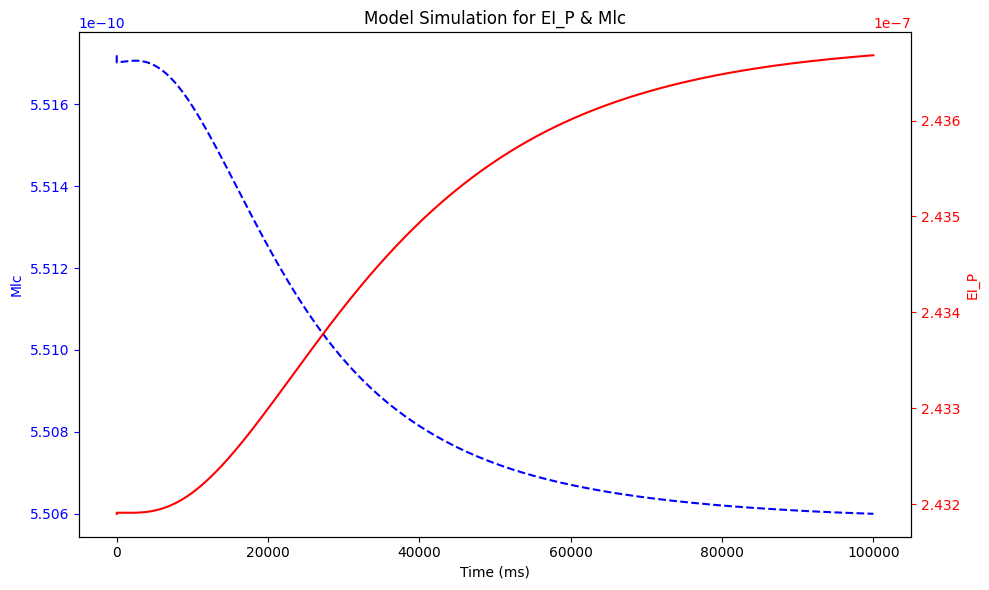

In [9]:
# Visualize if anything has possible control over EI_P

INPUT_NAME = "Mlc"
OUTPUT_NAME = "EI_P"

# Create Temporary ControlSBML (t = 500 change in glucose not in this? I think it may be bug-related?)
temporary_control_sbml = ControlSBML(ANTIMONY_MODEL_EI_P, figsize=(10, 5), markers=False,
                           input_names=[INPUT_NAME], output_names=[OUTPUT_NAME],
                           times=np.linspace(0, 100, 100000)) 

# Plot the model without displaying it
ts = temporary_control_sbml.plotModel(is_plot=False)
df = ts[[INPUT_NAME, OUTPUT_NAME]]
print(df)
#print(CONTROL_SBML)

# Create a figure with a single-axis
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the primary variable on the left axis
ax1.plot(ts.index, ts[INPUT_NAME], 'b--', label=INPUT_NAME)
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel(INPUT_NAME, color='b')
ax1.tick_params('y', colors='b')

# Create a second y-axis on the right
ax2 = ax1.twinx()
ax2.plot(ts.index, ts[OUTPUT_NAME], 'r-', label=OUTPUT_NAME)
ax2.set_ylabel(OUTPUT_NAME, color='r')
ax2.tick_params('y', colors='r')

# Title and legend
plt.title('Model Simulation for EI_P & Mlc')
fig.tight_layout()
plt.show()

Mlc seems like it could be an antagonist to the concentration of ``EI_P``. Note that I tried many different values for the time series to convert it to the right units, I tried across multiple orders of magnitude but nothing worked to detect the fluctuation at t = 500 minutes. For whatever reason it is giving a perturbation at t = 0 minutes so I thought that would be sufficient to view the relationships between different inputs and the output, like we see here. Now let us try a staircase: 

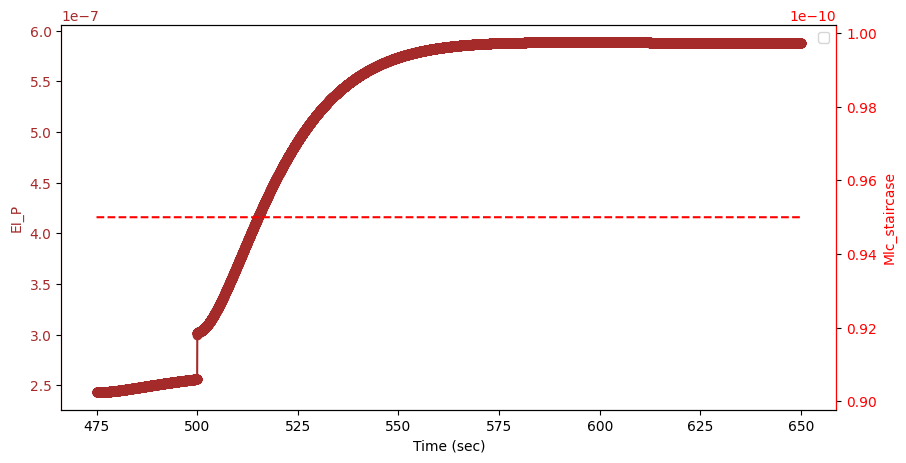

In [10]:
## Plot a Staircase Function & Look for Glucose Change at 500 minutes (NOT SEC)

# Create permanenent control sbml
CONTROL_SBML = ControlSBML(ANTIMONY_MODEL_EI_P, figsize=(10, 5), times=np.linspace(0, 1000, 100000), markers=False, 
                           input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])


# Plot staircase
_ = CONTROL_SBML.plotStaircaseResponse(initial_value=0.000000000095, final_value=0.000000000095, times=np.linspace(475, 650, 20000),
                                      )#ylim=[0.0000002, 0.0000003])

Luckily, there is no problem with the staircase function sensing the glucose spike at 500 minutes (despite the axis saying seconds). Additionally, this is a lower Mlc than up in the first part and we can see that EL_P went up higher than previously, let us proceed and perform an actual staircase analysis now:

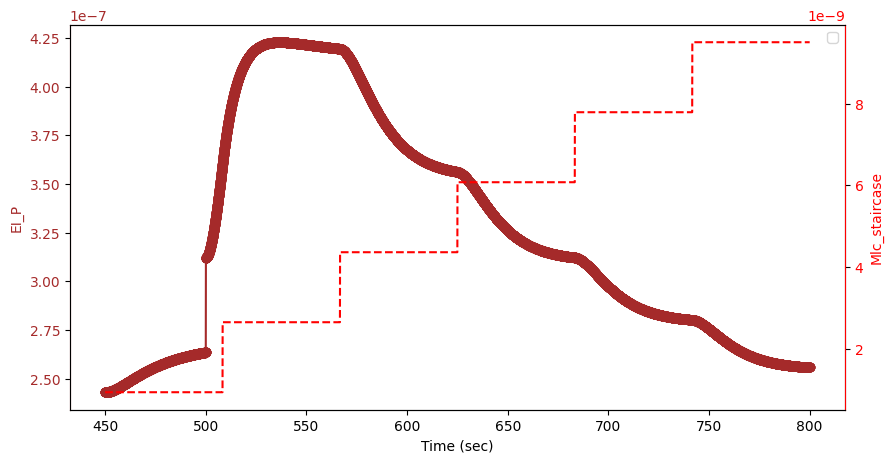

In [11]:
## Plot a Staircase Function & Find the Operating Region 

# Create permanenent control sbml
CONTROL_SBML = ControlSBML(ANTIMONY_MODEL_EI_P, figsize=(10, 5), times=np.linspace(0, 1000, 100000), markers=False, 
                           input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])


# Plot staircase
_ = CONTROL_SBML.plotStaircaseResponse(initial_value=0.00000000095, final_value=0.0000000095, times=np.linspace(450, 800, 20000),
                                      )#ylim=[0.0000002, 0.0000003])

We are way overshooting, remember we want to keep EL_P below 3.0e-7 M. This means our control is working, lowering Mlc does increase El_P, but it is increasing it too much. We do not want a spike that is going to throw our E. coli into a panic. Also remember that we do not care about time points before 500 minutes because it is a steady-state, stable system with no interesting behavior because the glucose concentration is fixed. It is more interesting to see a rapid perturbation and the recovery to equilibrium, as this is most likely what E. coli will more realistically experience in a bioreactor - a shutoff of glucose supplement and the rapid decline of any glucose left in the solution with the E. coli.

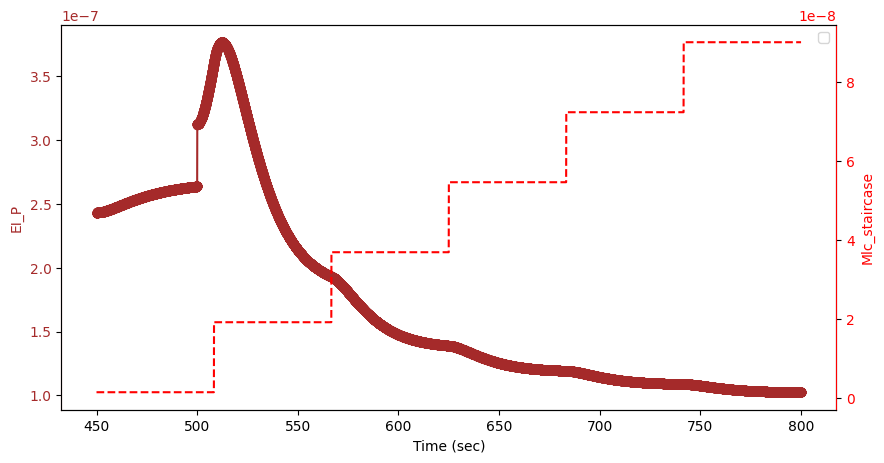

In [12]:
## Plot a Staircase Function & Find the Operating Region 

# Create permanenent control sbml
CONTROL_SBML = ControlSBML(ANTIMONY_MODEL_EI_P, figsize=(10, 5), times=np.linspace(0, 1000, 100000), markers=False, 
                           input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])


# Plot staircase
_ = CONTROL_SBML.plotStaircaseResponse(initial_value=0.0000000015, final_value=0.00000009, times=np.linspace(450, 800, 20000),
                                      )#ylim=[0.0000002, 0.0000003])

Initial [Mlc] is too low and the ending concentration is too high.

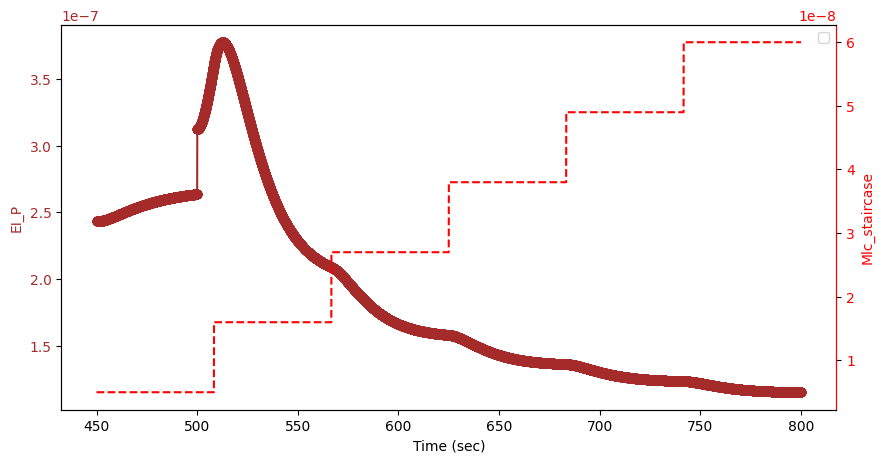

In [13]:
## Plot a Staircase Function & Find the Operating Region 

# Create permanenent control sbml
CONTROL_SBML = ControlSBML(ANTIMONY_MODEL_EI_P, figsize=(10, 5), times=np.linspace(0, 1000, 100000), markers=False, 
                           input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])


# Plot staircase
_ = CONTROL_SBML.plotStaircaseResponse(initial_value=0.000000005, final_value=0.00000006, times=np.linspace(450, 800, 20000),
                                      )#ylim=[0.0000002, 0.0000003])

The initial [Mlc] is starting to look great, but it is too harsh for the end. I think an interesting strategy to try is to start lowering Mlc.

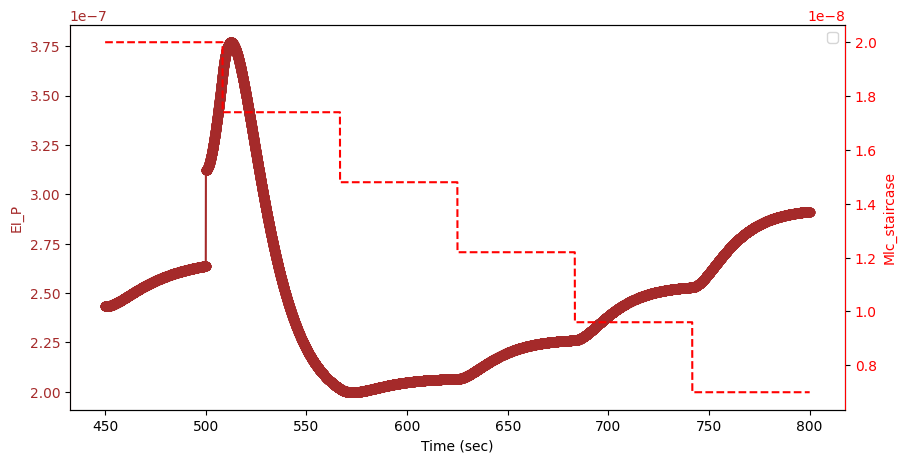

In [14]:
## Plot a Staircase Function & Find the Operating Region 

# Create permanenent control sbml
CONTROL_SBML = ControlSBML(ANTIMONY_MODEL_EI_P, figsize=(10, 5), times=np.linspace(0, 1000, 100000), markers=False, 
                           input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])


# Plot staircase
_ = CONTROL_SBML.plotStaircaseResponse(initial_value=0.00000002, final_value=0.000000007, times=np.linspace(450, 800, 20000),
                                      )#ylim=[0.0000002, 0.0000003])

Getting close! Let's increase our the end time to our goal, and while we're at it let's shoot for 1200 minutes (12 hours) the usual time E. coli will incubate after inducing plasmid expression (i.e., production of the desired product)!

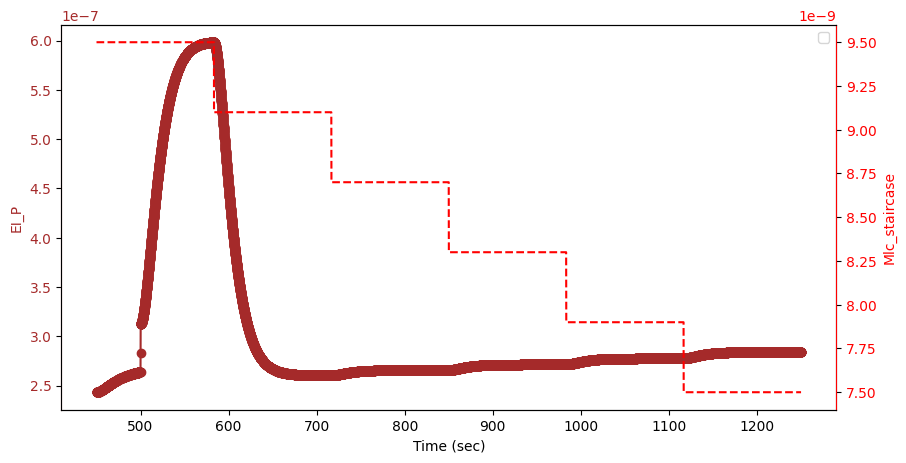

In [15]:
## Plot a Staircase Function & Find the Operating Region 

# Create permanenent control sbml
CONTROL_SBML = ControlSBML(ANTIMONY_MODEL_EI_P, figsize=(10, 5), times=np.linspace(0, 1000, 100000), markers=False, 
                           input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])


# Plot staircase
_ = CONTROL_SBML.plotStaircaseResponse(initial_value=0.0000000095, final_value=0.0000000075, times=np.linspace(450, 1250, 20000),
                                      )#ylim=[0.0000002, 0.0000003])

**Comments:** I think you can better isolate the time and EI_P values. See below.

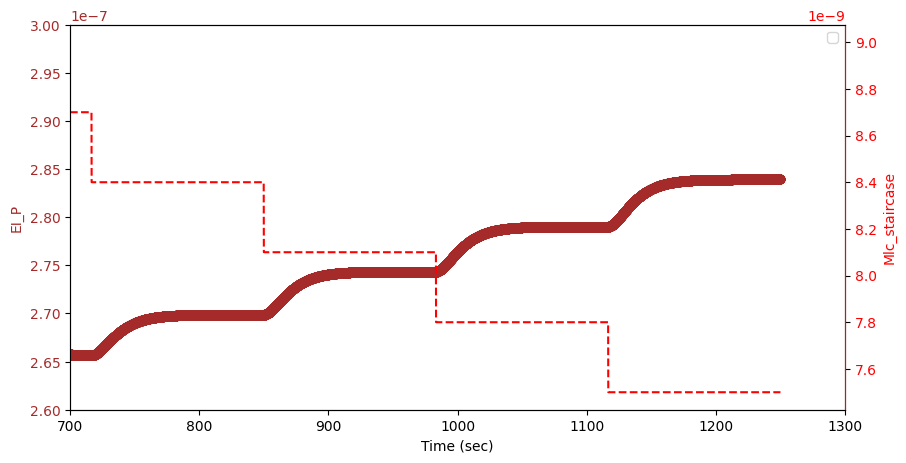

In [21]:
_ = CONTROL_SBML.plotStaircaseResponse(initial_value=0.000000009, final_value=0.0000000075, times=np.linspace(450, 1250, 20000),
                                      ylim=[0.00000026, 0.0000003], xlim=[700, 1300])

We have achieved the goals: 
* Keep the ``EI_P`` concentration in the range above 2.4e-7M at all costs for ideally 720 minutes (12 hours) after t > 500 minutes.
* Minimize or eliminate any potential concentration oscillations.
* With each additional step this setting time should also be within t = 30 minutes & the final ``EI_P`` should steady out.

We can modify a little bit more to aim to get:
* Converge to a stable, steady-state system after the glucose decrease within 30 minutes (or as quickly as possible, the new goal is 50 minutes).
* Do not have such a high ``EI_P`` initial spike after the glucose decrease.


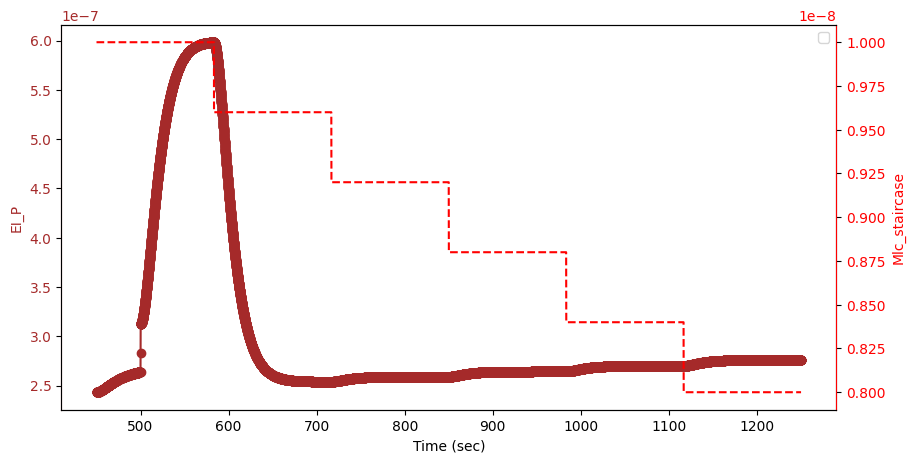

In [16]:
## Plot a Staircase Function & Find the Operating Region 

# Create permanenent control sbml
CONTROL_SBML = ControlSBML(ANTIMONY_MODEL_EI_P, figsize=(10, 5), times=np.linspace(0, 1000, 100000), markers=False, 
                           input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])


# Plot staircase
_ = CONTROL_SBML.plotStaircaseResponse(initial_value=0.00000001, final_value=0.000000008, times=np.linspace(450, 1250, 20000),
                                      )#ylim=[0.0000002, 0.0000003])

We did not achieve every control objective perfectly because of the difficulty of completely counteracting a seven orders of magnitude perturbation in glucose concentration at t = 500 minutes in a highly interconnected and sensitive biological system. Nonetheless, this was still a better outcome than expected and we achieved the following control objectives:
* Kept the ``EI_P`` concentration in the range above 2.4e-7 M for over 720 minutes (12 hours) past t = 500 minutes. Furthermore, it was below 3.0e-7 M for about 600 minutes and only missed this range in the beginning due to the extreme, exaggerated perturbation.
* Eliminated any potential concentration oscillations, although none were expected. 
* Converged to a stable, steady-state system after the glucose decreased within ~75 minutes before the staircase shift.
* With each additional step this setting time was drastically reduced to about ~30 minutes & the final ``EI_P`` steadied out between [2.4e-7 M, 3.0e-7 M].

Ultimately, the final plot above achieves the control objectives by stabilizing as a nearly horizontal line within the desired setpoints after the initial glucose perturbation at t = 500 minutes, seen as the right tail on the function. After the glucose perturbation, each step decrease in Mlc protein concentration increases the concentration of ``EI_P`` as expected since Mlc inhibits the production of EI protein. Thus, they are antagonistic. There are no oscillations about a setting point observed at any time which demonstrates that the second control objective was achieved. The third control objective can be noted at the time t = 575 minutes where the post-perturbation ``EI_P`` concentration stops growing and begins to drastically flatten out before the staircase decreases. Finally, the final control objective was achieved because the right tail is nearly horizontal and each step down on the staircase only increases the tail line for about 30 minutes before it becomes horizontal again. Furthermore, its horizontal ``EI_P`` concentration values are between 2.4e-7 M and 3.0e-7 M in this operating range.

Below, we provide the complete system definition.

1. SBML model: Nishio2008 - Design of the phosphotransferase system for enhanced glucose uptake in E. coli from Biomodels
1. Output: ``EI_P``
1. Input: ``Mlc``
1. Directional effect of the input on the output: Concave up ``EI_P`` decreases for stepwise ``Mlc`` increases
1. Operating region for the input: [0.8e-8 M, 1.0e-8 M]
1. Range of outputs that can be achieved outside of large glucose perturbation [2.4e-7 M, 3.0e-7 M]
1. Range of outputs that can be achieved including large glucose perturbation [2.4e-7 M, 6.0e-7 M]

**Comments:** It looks like EI_P is monotone decreasing in Mlc. The concave part appears to be an initial transient?